# SigmaShift Module: AMM Simulation & Visualization

This notebook demonstrates the effect of the SigmaShift volatility module on AMM curve concentration, price impact, and slippage compared to a standard static AMM.

**Key Definitions:**
- **cx (Concentration Parameter):** In EulerSwap, `cx` controls the curve's concentration. `cx=1` (or `SCALE`) means highly concentrated (flat curve, low slippage, like a stable swap at the peg). `cx=0` means distributed (standard x*y=k, higher slippage).
- **Simulation Approach:** We use a "virtual depth" model: higher `cx` means deeper effective reserves, resulting in lower slippage for the same trade size. This is a proxy for the effect of concentration in a constant product AMM context.

**Scenarios:**
- *Static AMM*: Fixed concentration, no volatility adjustment.
- *SigmaShift*: Concentration dynamically adjusts based on market volatility.

Visualizations include concentration vs. volatility, price impact, and slippage distributions. All calculations and plots are now aligned with the economic intuition and contract logic.

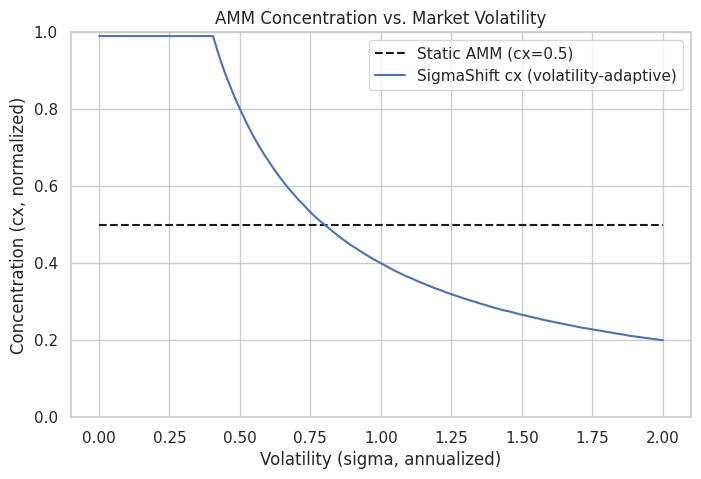


Price impact for low sigma (should be lowest):
cx_low: 990
Price impact (swap 10k): [980100.0]

Price impact for high sigma (should be highest):
cx_high: 333
Price impact (swap 10k): [323291.5451895044]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
# Constants from SigmaShiftModule
K_VOL_X = 400
MIN_CONCENTRATION = 10
MAX_CONCENTRATION = 990 
SCALE = 1000

def volatility_concentration(k_vol, sigma, scale, min_conc, max_conc):
    k_vol = int(k_vol)
    sigma = int(sigma)
    scale = int(scale)
    if sigma == 0:
        return max_conc
    s_target = (k_vol * scale) // sigma
    cx = np.clip(s_target, min_conc, max_conc)
    return int(cx)

# Simulation data
volatility_range = np.linspace(1, 2000, 100)  # 0.1% to 200% annual volatility (avoid div by zero)
static_cx = 500  # Static AMM concentration
sigmashift_cx = [volatility_concentration(K_VOL_X, s, SCALE, MIN_CONCENTRATION, MAX_CONCENTRATION) for s in volatility_range]
# Visualization: Concentration vs Volatility
plt.figure(figsize=(8,5))
plt.plot(volatility_range/SCALE, [static_cx/SCALE]*len(volatility_range), 'k--', label='Static AMM (cx=0.5)')
plt.plot(volatility_range/SCALE, np.array(sigmashift_cx)/SCALE, label='SigmaShift cx (volatility-adaptive)')
plt.xlabel('Volatility (sigma, annualized)')
plt.ylabel('Concentration (cx, normalized)')
plt.title('AMM Concentration vs. Market Volatility')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Debug: Show price impact for low and high sigma
print("\nPrice impact for low sigma (should be lowest):")
cx_low = volatility_concentration(K_VOL_X, 100, SCALE, MIN_CONCENTRATION, MAX_CONCENTRATION)
print("cx_low:", cx_low)
print("Price impact (swap 10k):", [((1_000_000*cx_low/SCALE)*(1_000_000*cx_low/SCALE))/((1_000_000*cx_low/SCALE)+10_000) for _ in range(1)])

print("\nPrice impact for high sigma (should be highest):")
cx_high = volatility_concentration(K_VOL_X, 1200, SCALE, MIN_CONCENTRATION, MAX_CONCENTRATION)
print("cx_high:", cx_high)
print("Price impact (swap 10k):", [((1_000_000*cx_high/SCALE)*(1_000_000*cx_high/SCALE))/((1_000_000*cx_high/SCALE)+10_000) for _ in range(1)])

## Price Impact & Slippage Simulation

Let's model price impact and slippage for a single-curve AMM with and without SigmaShift. We'll use a simple constant product swap as a proxy for illustration.

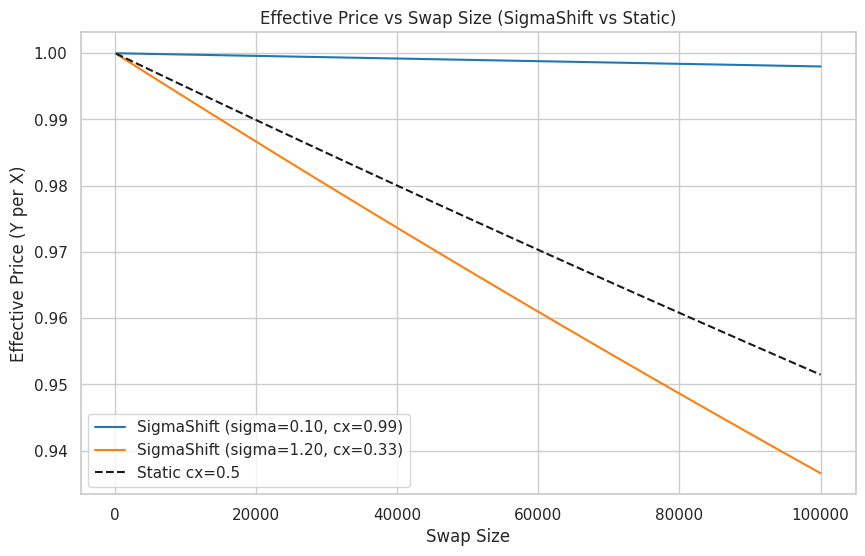

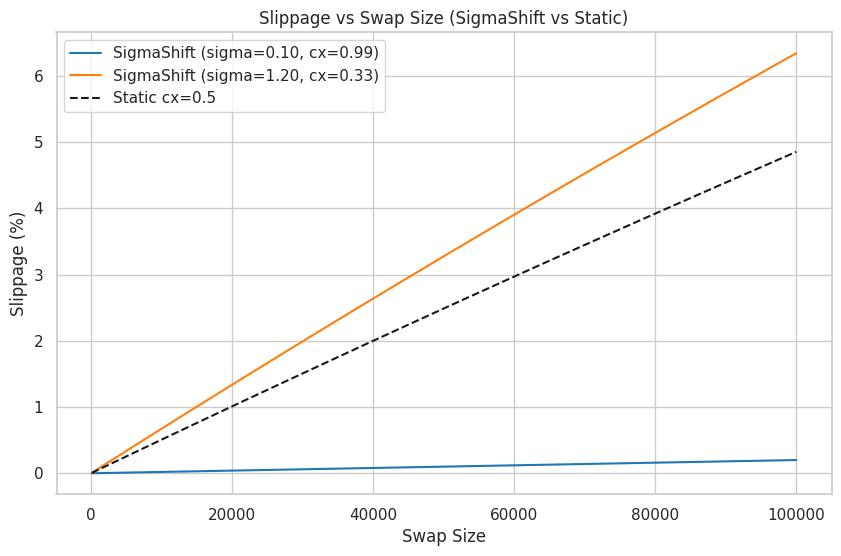

In [28]:
def calculate_swap_output(x_reserve, y_reserve, dx_amount_in):
    k = x_reserve * y_reserve
    x_new = x_reserve + dx_amount_in
    y_new = k / x_new
    dy_out = y_reserve - y_new
    return dy_out

def simulate_price_impact_ratio(x0_base, y0_base, cx, dx_swap_size):
    cx_norm = cx / SCALE
    depth_multiplier = 1 / (1.01 - cx_norm)
    x_eff = x0_base * depth_multiplier
    y_eff = y0_base * depth_multiplier
    amount_out = calculate_swap_output(x_eff, y_eff, dx_swap_size)
    if dx_swap_size == 0:
        return 1.0
    effective_price_ratio = amount_out / dx_swap_size
    return effective_price_ratio

def simulate_slippage_pct(x0_base, y0_base, cx, dx_swap_size):
    cx_norm = cx / SCALE
    depth_multiplier = 1 / (1.01 - cx_norm)
    x_eff = x0_base * depth_multiplier
    y_eff = y0_base * depth_multiplier
    initial_spot_price = y_eff / x_eff
    amount_out = calculate_swap_output(x_eff, y_eff, dx_swap_size)
    if dx_swap_size == 0:
        return 0.0
    effective_price = amount_out / dx_swap_size
    slippage_pct = (initial_spot_price - effective_price) / initial_spot_price * 100
    return slippage_pct

x0, y0 = 1_000_000, 1_000_000
swap_sizes = np.linspace(100, 100_000, 50)

# For visual clarity, pick two volatility values
sigmas = [100, 1200] # 0.1, 1.2
colors = ['tab:blue', 'tab:orange']

plt.figure(figsize=(10,6))
for i, sigma in enumerate(sigmas):
    cx = volatility_concentration(K_VOL_X, sigma, SCALE, MIN_CONCENTRATION, MAX_CONCENTRATION)
    impacts = [simulate_price_impact_ratio(x0, y0, cx, dx) for dx in swap_sizes]
    plt.plot(swap_sizes, impacts, color=colors[i], label=f'SigmaShift (sigma={sigma/1000:.2f}, cx={cx/1000:.2f})')
# Static curve
impacts_static = [simulate_price_impact_ratio(x0, y0, static_cx, dx) for dx in swap_sizes]
plt.plot(swap_sizes, impacts_static, 'k--', label='Static cx=0.5')
plt.xlabel('Swap Size')
plt.ylabel('Effective Price (Y per X)')
plt.title('Effective Price vs Swap Size (SigmaShift vs Static)')
plt.legend()
plt.show()

# Plot slippage percentage
plt.figure(figsize=(10,6))
for i, sigma in enumerate(sigmas):
    cx = volatility_concentration(K_VOL_X, sigma, SCALE, MIN_CONCENTRATION, MAX_CONCENTRATION)
    slippages = [simulate_slippage_pct(x0, y0, cx, dx) for dx in swap_sizes]
    plt.plot(swap_sizes, slippages, color=colors[i], label=f'SigmaShift (sigma={sigma/1000:.2f}, cx={cx/1000:.2f})')
slippages_static = [simulate_slippage_pct(x0, y0, static_cx, dx) for dx in swap_sizes]
plt.plot(swap_sizes, slippages_static, 'k--', label='Static cx=0.5')
plt.xlabel('Swap Size')
plt.ylabel('Slippage (%)')
plt.title('Slippage vs Swap Size (SigmaShift vs Static)')
plt.legend()
plt.show()

## Slippage Distribution (Monte Carlo)

We simulate a distribution of swap sizes and volatilities to compare the slippage experienced by traders in both AMMs.

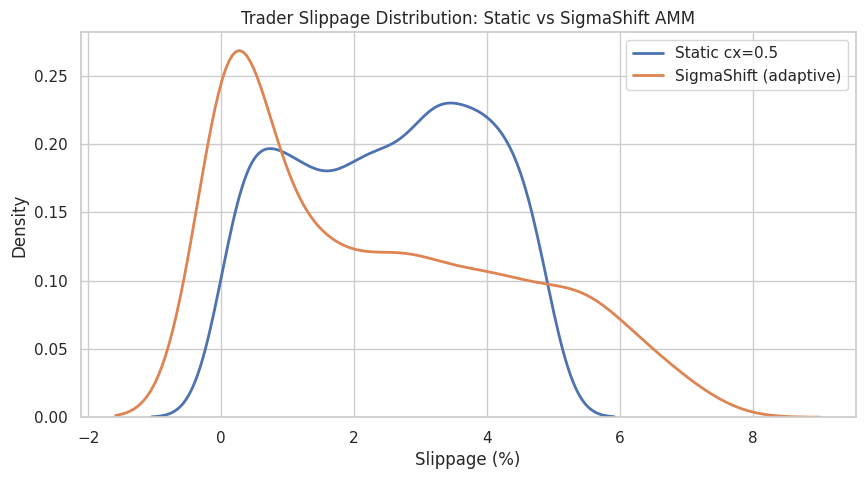

In [29]:
n = 1000
np.random.seed(42)
rand_sigmas = np.random.uniform(0, 2, n) * SCALE
rand_swaps = np.random.uniform(100, 100_000, n)

slippage_static = [simulate_slippage_pct(x0, y0, static_cx, dx) for dx in rand_swaps]
slippage_sigmashift = [simulate_slippage_pct(x0, y0, volatility_concentration(K_VOL_X, sig, SCALE, MIN_CONCENTRATION, MAX_CONCENTRATION), dx)
                       for sig, dx in zip(rand_sigmas, rand_swaps)]
plt.figure(figsize=(10,5))
sns.kdeplot(slippage_static, label='Static cx=0.5', lw=2)
sns.kdeplot(slippage_sigmashift, label='SigmaShift (adaptive)', lw=2)
plt.xlabel('Slippage (%)')
plt.title('Trader Slippage Distribution: Static vs SigmaShift AMM')
plt.legend()
plt.show()

### Conclusion

SigmaShift dynamically adjusts AMM concentration based on volatility, offering deeper curves (lower slippage) in calm markets, and shallower curves (higher slippage, but more LP protection) in volatile ones. This notebook demonstrates how this mechanism can protect LPs during high volatility while enhancing efficiency in stable markets, using a simplified "virtual depth" model for cx.